In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import xarray as xr
from IPython.display import HTML

from tool.dataset import NetCDFDataset
from tool.loss import RMSELoss
from tool.utils import Util, ImgUtil

## Loading Data With Different Resolutions

In [3]:
file_hr = './data/eta_eulerian_resolution_20.0km.nc'
file_lr = './data/eta_eulerian_resolution_100.0km.nc'

In [4]:
# loading outputs from shallow water model and transposing dimensions
ds_hr = xr.open_mfdataset(file_hr).transpose('time', 'y', 'x')
ds_lr = xr.open_mfdataset(file_lr).transpose('time', 'y', 'x')

In [5]:
da_hr = ds_hr.rename({'__xarray_dataarray_variable__':'eta'}).eta
da_lr = ds_lr.rename({'__xarray_dataarray_variable__':'eta'}).eta

In [6]:
# interpolation - from 100x100 to 20x20
da_hr_interp = da_hr.interp(y=da_lr.y, x=da_lr.x, method='linear')
da_hr_interp_v = da_hr_interp.values

In [7]:
# filtering only time steps present in coarse resolution
da_hr_interp_subset = da_hr_interp.isel(time=slice(0, da_hr_interp.time.size - 1, 5))

In [8]:
da_lr_v = da_lr.values
da_hr_interp_subset_v = da_hr_interp_subset.values

In [9]:
da_hr_interp_subset

<xarray.DataArray 'eta' (time: 7331, y: 20, x: 20)>
dask.array<shape=(7331, 20, 20), dtype=float64, chunksize=(7331, 20, 20)>
Coordinates:
  * time     (time) float64 0.0 353.6 707.1 ... 2.591e+06 2.591e+06 2.592e+06
  * y        (y) float64 -1e+06 -9e+05 -8e+05 -7e+05 ... 6e+05 7e+05 8e+05 9e+05
  * x        (x) float64 0.0 1e+05 2e+05 3e+05 ... 1.7e+06 1.8e+06 1.9e+06

In [10]:
da_lr

<xarray.DataArray 'eta' (time: 7331, y: 20, x: 20)>
dask.array<shape=(7331, 20, 20), dtype=float64, chunksize=(7331, 20, 20)>
Coordinates:
  * time     (time) float64 0.0 353.6 707.1 ... 2.591e+06 2.591e+06 2.592e+06
  * y        (y) float64 -1e+06 -9e+05 -8e+05 -7e+05 ... 6e+05 7e+05 8e+05 9e+05
  * x        (x) float64 0.0 1e+05 2e+05 3e+05 ... 1.7e+06 1.8e+06 1.9e+06

### Loading Predictions

In [20]:
def load_predictions(data, hora):
    folder = '/home/guinelli/mestrado/stconvs2s/output/full-dataset/predictions/stconvs2s-r/'
    
    inputs = torch.load(folder + 'shalow_water_step20_4_' + data + '-' + hora + '_input.pt')
    targets = torch.load(folder + 'shalow_water_step20_4_' + data + '-' + hora + '_target.pt')
    predictions = torch.load(folder + 'shalow_water_step20_4_' + data + '-' + hora + '_predictions.pt')
    
    return inputs, targets, predictions

In [21]:
inputs, targets, predictions = load_predictions(data='20210303', hora='200922')

In [22]:
np_inputs = inputs.cpu().numpy()
np_targets = targets.cpu().numpy()
np_predictions = predictions.cpu().numpy()

## Comparing Low vs High Resolution

In [30]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y) + 1e-6 )

In [31]:
def get_loss(target, output):
    rmse_loss, mae_loss, x = [], [], []
    #criterium = torch.nn.MSELoss()
    criterium = RMSELoss()

    for i in range(target.shape[2]):
        yhat, y = output[:,:,i,:,:], target[:,:,i,:,:]
        yhat, y = torch.from_numpy(yhat), torch.from_numpy(y)
        rmse_loss.append(criterium(yhat, y))
        mae_loss.append(F.l1_loss(yhat, y))
        
    return rmse_loss, mae_loss

In [32]:
rmse_loss, mae_loss = get_loss(da_hr_interp_subset_v[None, None], da_lr_v[None, None])

In [54]:
fim = 80
inicio = fim-1
c = RMSELoss()
print(RMSELoss()(predictions[:,2:], targets[:,2:]))
print(F.l1_loss(predictions[:,2:], targets[:,2:]))
rmse_loss_2, mae_loss_2 = get_loss(np_predictions[:,2:], np_targets[:,2:])
#rmse_loss_2, mae_loss_2 = get_loss(np_predictions[inicio:fim], np_targets[inicio:fim])

tensor(0.0017, device='cuda:0')
tensor(0.0010, device='cuda:0')


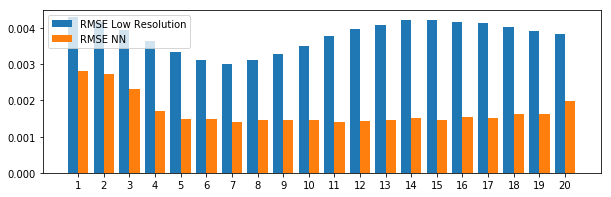

In [55]:
fig, ax = plt.subplots(figsize=(10,3))
ax.bar(np.arange(1,21)-0.2, rmse_loss[:40:2], width=0.4, label="RMSE Low Resolution")
ax.bar(np.arange(1,21)+0.2, rmse_loss_2,  width=0.4, label="RMSE NN")
ax.set_xticks(np.arange(1,21))
plt.legend(loc="upper left")

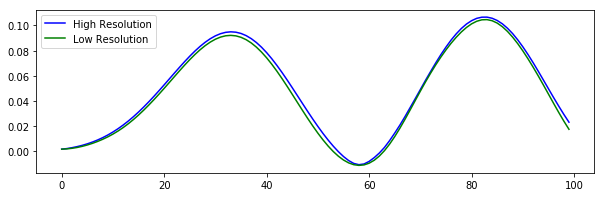

In [56]:
length = 100
shift = 0
f = shift + length

plt.figure(figsize=(10,3))
plt.plot(np.arange(shift, f), da_hr_interp_subset_v[shift:f,0,0], "-b", label="High Resolution")
plt.plot(np.arange(shift, f), da_lr_v[shift:f,0,0], "-g", label="Low Resolution")
plt.legend(loc="upper left")

plt.show()

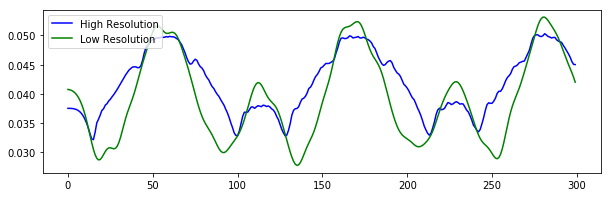

In [57]:
length = 300
shift = 0
f = shift + length

plt.figure(figsize=(10,3))
plt.plot(np.arange(shift, f), da_hr_interp_subset_v[shift:f,5,5], "-b", label="High Resolution")
plt.plot(np.arange(shift, f), da_lr_v[shift:f,5,5], "-g", label="Low Resolution")
plt.legend(loc="upper left")

plt.show()

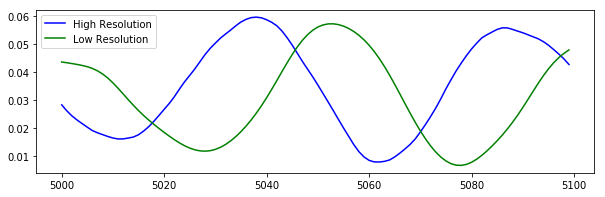

In [58]:
length = 100
shift = 5000
f = shift + length

plt.figure(figsize=(10,3))
plt.plot(np.arange(shift, f), da_hr_interp_subset_v[shift:f,10,10], "-b", label="High Resolution")
plt.plot(np.arange(shift, f), da_lr_v[shift:f,10,10], "-g", label="Low Resolution")
plt.legend(loc="upper left")

plt.show()

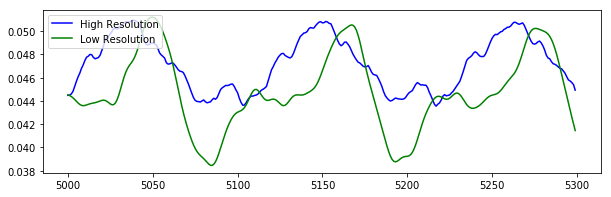

In [60]:
length = 300
shift = 5000
f = shift + length

plt.figure(figsize=(10,3))
plt.plot(np.arange(shift, f), da_hr_interp_subset_v[shift:f,5,5], "-b", label="High Resolution")
plt.plot(np.arange(shift, f), da_lr_v[shift:f,5,5], "-g", label="Low Resolution")
plt.legend(loc="upper left")

plt.show()

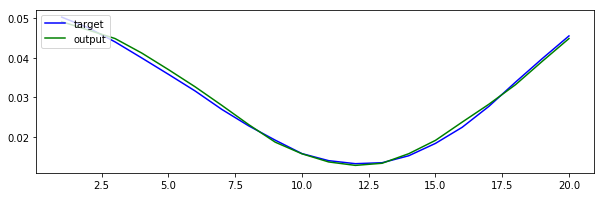

In [186]:
length = np_targets.shape[2]

plt.figure(figsize=(10,3))
plt.plot(np.arange(1,length+1), np_targets[0,2,:,10,10], "-b", label="target")
plt.plot(np.arange(1,length+1), np_predictions[0,2,:,10,10], "-g", label="output")
plt.legend(loc="upper left")
#plt.ylim(0.04, 0.06)
plt.show()

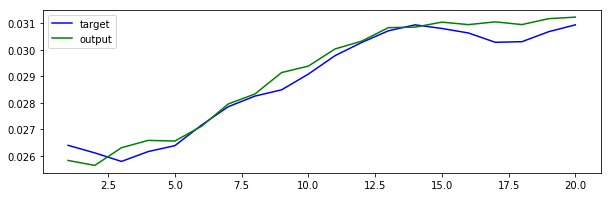

In [187]:
length = np_targets.shape[2]

plt.figure(figsize=(10,3))
plt.plot(np.arange(1,length+1), np_targets[0,2,:,15,15], "-b", label="target")
plt.plot(np.arange(1,length+1), np_predictions[0,2,:,15,15], "-g", label="output")
plt.legend(loc="upper left")
plt.show()

## Loading Trained DL Model

In [64]:
def load_checkpoint(filename, model_name, dataset_type=None, model=None, optimizer=None):
    if not(os.path.isabs(filename)):
        filename = os.path.join('/home/guinelli/mestrado/stconvs2s/output', dataset_type, 'checkpoints', model_name.lower(), filename)  
    epoch, loss = 0.0, 0.0
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        name = os.path.basename(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f'=> Loaded checkpoint {name} (best epoch: {epoch}, validation rmse: {loss:.4f})')
    else:
        print(f'=> No checkpoint found at {filename}')

    return model

In [65]:
from model.stconvs2s import STConvS2S_R

In [71]:
# same parameters from training
x_shape = [1, 3, 5, 20, 20]
num_layers = 3
hidden_dim = 32
kernel_size = 5
device = torch.device('cuda')
dropout_rate = 0
step = 20

In [72]:
opt_params = {
    'lr': 0.001,
    'alpha': 0.9,
    'eps': 1e-6
}

In [73]:
model = STConvS2S_R(x_shape, num_layers, hidden_dim, kernel_size, device, dropout_rate, step)
model.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)

In [74]:
# files with checkpoints from each training epoch
filename = 'shalow_water_step20_4_20210303-200922.pth.tar'
dataset_type = 'full-dataset'
model_name = 'stconvs2s-r'

In [75]:
# loading weigths from best epoch
model = load_checkpoint(filename, model_name, dataset_type, model, optimizer)

=> Loaded checkpoint shalow_water_step20_4_20210303-200922.pth.tar (best epoch: 26, validation rmse: 0.0019)


## Getting Data for Simulation

In [96]:
ds = xr.open_mfdataset('/home/guinelli/mestrado/stconvs2s/data/dataset-shallow-water-3ch-20.0km-yseq20-ystep10.nc')

In [99]:
ds_x = torch.from_numpy(ds.x.values).float().permute(0, 4, 1, 2, 3)
ds_y = torch.from_numpy(ds.y.values).float().permute(0, 4, 1, 2, 3)

In [100]:
x_np = ds_x.cpu().numpy()
y_np = ds_y.cpu().numpy()

In [101]:
# getting last 20% of the dataset for test
start_i = int(np.ceil(ds.x.shape[0] * 0.8))
start_i

29128

In [119]:
# generating input and expected output (target)
ds = x_np[start_i::10,:,1][:245].transpose(1,0,2,3)
x, y = ds[:,0:5][None], ds[:,5:][None]

In [120]:
# aprox. 12min * 240 (aprox. 2 days)
x.shape, y.shape

((1, 3, 5, 20, 20), (1, 3, 240, 20, 20))

### Predicting

In [123]:
def make_predictions(model, initial_input, steps, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        i_input = initial_input
        i_input = i_input.to(device)
        for i in range(steps):
            output = model(i_input)
            predictions.append(output)
            i_input = output[:,:,-5:]
    
    return predictions

In [124]:
pred = make_predictions(model=model, initial_input=torch.tensor(x, dtype=torch.float), steps=12, device=device)

In [125]:
# concatenating predictions
pred = torch.cat(pred, dim=2)

In [126]:
np_pred = pred.cpu().numpy()

In [127]:
np_pred.shape

(1, 3, 240, 20, 20)

## Analysing Predictions

In [133]:
# organizing data to plot a gif
diff = np_pred[0,2] - y[0,2]
data = [y[0,2],
        np_pred[0,2],
        diff]
titles = ['Target', 'Output', 'Diff']

In [136]:
%%capture
# creating gif animation
%matplotlib notebook
g = ImgUtil(data, titles, np.min(data), np.max(data))
# frames indicates how many steps should be printed
anim = g.get_animation_gif(frames=240, cmap='viridis')

In [137]:
HTML(anim.to_jshtml())

In [141]:
type(np_pred[0,2,0,0,0]),type(np.float32(y)[0,0,0,0,0])

(numpy.float32, numpy.float32)

In [142]:
rmse_nn, mae_nn = get_loss(np_pred[:,2:], y[:,2:])
x = np.arange(1,len(rmse_loss)+1)

In [143]:
rmse_lr, mae_lr = get_loss(da_hr_interp_subset_v[::2][None, None], da_lr_v[::2][None, None])

In [144]:
len(rmse_loss),len(x)

(7331, 7331)

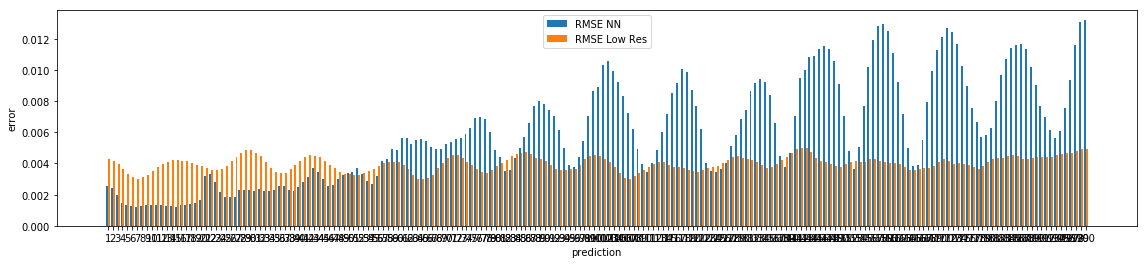

In [150]:
%matplotlib inline
width = 0.4
fig_bar = plt.figure(figsize=(15,3))
ax = fig_bar.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(x[:200])+1)-width/2, rmse_nn[:200], width=0.4, label='RMSE NN')
ax.bar(np.arange(1,len(x[:200])+1)+width/2, rmse_lr[:200], width=0.4, label='RMSE Low Res')
ax.set_xticks(x[:200])
plt.ylabel('error')
plt.xlabel('prediction')
plt.legend(loc="upper center")

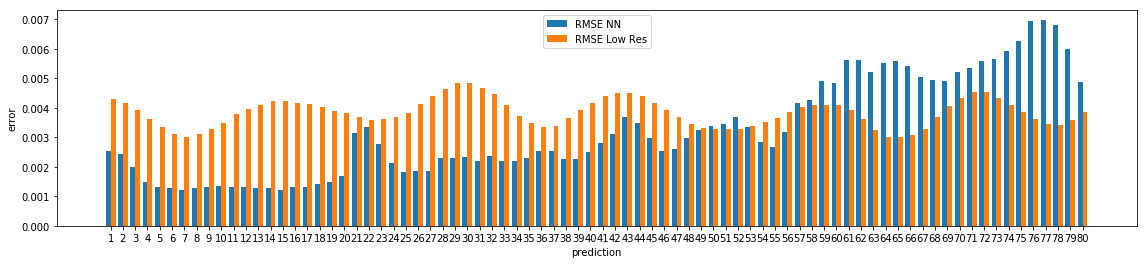

In [183]:
%matplotlib inline
width = 0.4
fig_bar = plt.figure(figsize=(15,3))
ax = fig_bar.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(x[:80])+1)-width/2, rmse_nn[:80], width=0.4, label='RMSE NN')
ax.bar(np.arange(1,len(x[:80])+1)+width/2, rmse_lr[:80], width=0.4, label='RMSE Low Res')
#ax.plot(np.arange(1,len(x[:200])+1)-width/2, rmse_nn[:200], width=0.4, label='RMSE NN')
#ax.plot(np.arange(1,len(x[:200])+1)+width/2, rmse_lr[:200], width=0.4, label='RMSE Low Res')
ax.set_xticks(x[:80])
plt.ylabel('error')
plt.xlabel('prediction')
plt.legend(loc="upper center")

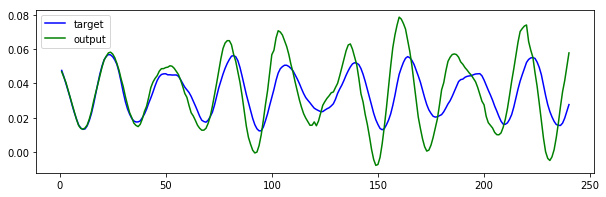

In [172]:
length = 240

plt.figure(figsize=(10,3))
plt.plot(np.arange(1,length+1), y[0,2,:length,10,10], "-b", label="target")
plt.plot(np.arange(1,length+1), np_pred[0,2,:length,10,10], "-g", label="output")
plt.legend(loc="upper left")
#plt.ylim(0.036, 0.154)
plt.show()

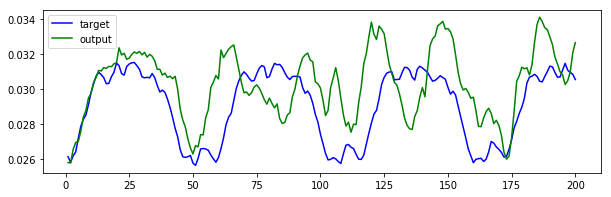

In [173]:
length = 200

plt.figure(figsize=(10,3))
plt.plot(np.arange(1,length+1), y[0,2,:length,15,15], "-b", label="target")
plt.plot(np.arange(1,length+1), np_pred[0,2,:length,15,15], "-g", label="output")
plt.legend(loc="upper left")
#plt.ylim(0.06, 0.04)
plt.show()

## Conservação de Energia

In [174]:
da_hr_interp_subset_v.shape, da_lr_v.shape, da_hr[1::5].shape

((7331, 20, 20), (7331, 20, 20), (7331, 100, 100))

In [181]:
sum_nn = np.squeeze(np_pred[:,2:]).sum(1).sum(1)
sum_lr = da_lr_v[::2].sum(1).sum(1)
sum_hr = da_hr_interp_subset_v[::2].sum(1).sum(1)
sum_hr2 = da_hr.values[::10].sum(1).sum(1) / 25

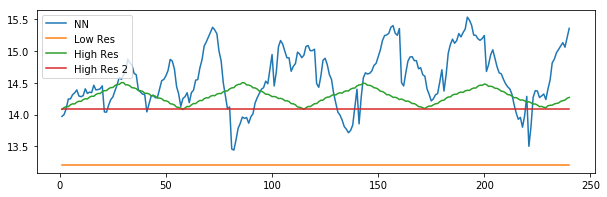

In [182]:
length = len(sum_nn)

plt.figure(figsize=(10,3))
plt.plot(np.arange(1,length+1), sum_nn[:length], label="NN")
plt.plot(np.arange(1,length+1), sum_lr[:length], label="Low Res")
plt.plot(np.arange(1,length+1), sum_hr[:length], label="High Res")
plt.plot(np.arange(1,length+1), sum_hr2[:length], label="High Res 2")
plt.legend(loc="upper left")
#plt.ylim(0.06, 0.04)
plt.show()